### Funnel Analysis

Goal

The goal is to perform funnel analysis for an e-commerce website.

Typically, websites have a clear path to conversion: for instance, you land on the home page, then you search, select a product and buy it. At each of these steps, some users will drop off and leave the site. The sequence of pages that leads to conversion is called ‘funnel’ .

Data Science can have a tremendous impact on funnel optimization. 
Funnel analysis allows to understand where/when our users abandon the website. It gives crucial insights on user behavior and on ways to improve the user experience as well as it often allows to discover bugs.

Challenge Description

You are looking at data from an e-commerce website. The site is very simple and has just 4 pages:

1. The first page is the home page. When you come to the site for the first time, you can only land on the home page as a first page.
2. From the home page, the user can perform a search and land on the search page.
3. From the search page, if the user clicks on a product, she will get to the payment page, where she is asked to provide payment information in order to buy that product.
4. If she does decide to buy, she ends up on the confirmation page


The company CEO isn’t very happy with the company sales and, especially, sales coming from new users. Therefore, she asked you to investigate whether there is something wrong in the conversion funnel or, in general, if you can create hypotheses on how conversion rate could be improved.

Specifically, she is interested in :

1. A full picture of funnel conversion rate for both desktop and mobile
2. Some insights on what the product team should focus on in order to improve conversion rate as well as any anything you might discover that could help improve conversion rate.


##### Import Library and Read Data

In [6]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)
  
import  warnings
warnings.simplefilter('ignore')

from plotly import graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
np.random.seed(4684)
    
from datetime import datetime

%matplotlib inline 

user_table - info about the user

Columns:
user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables
date : the date when the user firstly landed on the site
device : user device. Can be mobile or desktop
sex : male/female

home_page_table - Users who landed on the home page

Columns:
user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables
page : it is always home_page.

search_page_table - Users who landed on the search_page

Columns:
user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables
page : it is always search_page

payment_page_table - Users who landed on the payment_page

Columns:
user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables
page : it is always payment_page

payment_confirmation_table - Users who landed on the payment_confirmation_table. That is, these are the users who bought the product.

Columns:
user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables
page : it is always payment_confirmation_page

In [13]:
user = pd.read_csv('./Funnel_Analysis/user_table.csv', parse_dates=['date'])
print(user.info())
user.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 4 columns):
user_id    90400 non-null int64
date       90400 non-null datetime64[ns]
device     90400 non-null object
sex        90400 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.8+ MB
None


,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [14]:
home_page = pd.read_csv('./Funnel_Analysis/home_page_table.csv')
print(home_page.info())
home_page.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 2 columns):
user_id    90400 non-null int64
page       90400 non-null object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB
None


,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [15]:
search = pd.read_csv('./Funnel_Analysis/search_page_table.csv')
print(search.info())
search.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45200 entries, 0 to 45199
Data columns (total 2 columns):
user_id    45200 non-null int64
page       45200 non-null object
dtypes: int64(1), object(1)
memory usage: 706.4+ KB
None


,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [19]:
confirm = pd.read_csv('./Funnel_Analysis/payment_confirmation_table.csv')
print(confirm.info())
confirm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 2 columns):
user_id    452 non-null int64
page       452 non-null object
dtypes: int64(1), object(1)
memory usage: 7.2+ KB
None


,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


In [21]:
payment = pd.read_csv('./Funnel_Analysis/payment_page_table.csv')
print(payment.info())
payment.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6030 entries, 0 to 6029
Data columns (total 2 columns):
user_id    6030 non-null int64
page       6030 non-null object
dtypes: int64(1), object(1)
memory usage: 94.3+ KB
None


,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page


In [67]:
# Merge Datasets 
data = pd.merge(left=user, right=home_page, how='left', on='user_id')
data = pd.merge(left=data, right=search, how='left', on='user_id', suffixes=('_home', '_search'))
data = pd.merge(left=data, right=payment, how='left', on='user_id')
data = pd.merge(left=data, right=confirm, how='left', on='user_id', suffixes=('_payment', '_confirmation'))
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 8 columns):
user_id              90400 non-null int64
date                 90400 non-null datetime64[ns]
device               90400 non-null object
sex                  90400 non-null object
page_home            90400 non-null object
page_search          45200 non-null object
page_payment         6030 non-null object
page_confirmation    452 non-null object
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 6.2+ MB


##### Q1: Converison rate 

In [80]:
# Funnel Map by plotly

In [168]:
test = pd.DataFrame(data.count()[4:8]).reset_index()
test.rename(columns={'index':'variable',0:'counts'},inplace=True)
print("Overall Converison rate:", round(100*452/90400,2),"%")
test

Overall Converison rate: 0.5 %


,variable,counts
0,page_home,90400
1,page_search,45200
2,page_payment,6030
3,page_confirmation,452


In [169]:
fig = go.Figure(go.Funnel(
    y = test['variable'],
    x = test['counts'],
    textinfo = "value+percent initial",))
fig.show()

In [152]:
deviceGroup = pd.DataFrame(data.groupby('device').count())
deviceGroup = (deviceGroup.T).loc[test['variable'],:].reset_index()
deviceGroup

device,index,Desktop,Mobile
0,page_home,60200,30200
1,page_search,30100,15100
2,page_payment,3010,3020
3,page_confirmation,150,302


In [154]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Desktop',
    y = deviceGroup['index'],
    x = deviceGroup['Desktop'],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = 'Mobile',
    orientation = "h",
    y = deviceGroup['index'],
    x = deviceGroup['Mobile'],
    textinfo = "value+percent total"))

In [156]:
sexGroup = pd.DataFrame(data.groupby('sex').count())
sexGroup = (sexGroup.T).loc[test['variable'],:].reset_index()
sexGroup

sex,index,Female,Male
0,page_home,45075,45325
1,page_search,22676,22524
2,page_payment,3100,2930
3,page_confirmation,241,211


In [159]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Female',
    y = sexGroup['index'],
    x = sexGroup['Female'],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = 'Male',
    orientation = "h",
    y = sexGroup['index'],
    x = sexGroup['Male'],
    textinfo = "value+percent total"))

In [160]:
probNext = 1- pd.DataFrame(data.isnull().sum()/len(data))
probNext.rename(columns={0:'conversion'},inplace=True)
probNext = probNext[4:8]
probNext.reset_index(inplace=True)
probNext

,index,conversion
0,page_home,1.000000
1,page_search,0.500000
2,page_payment,0.066704
3,page_confirmation,0.005000


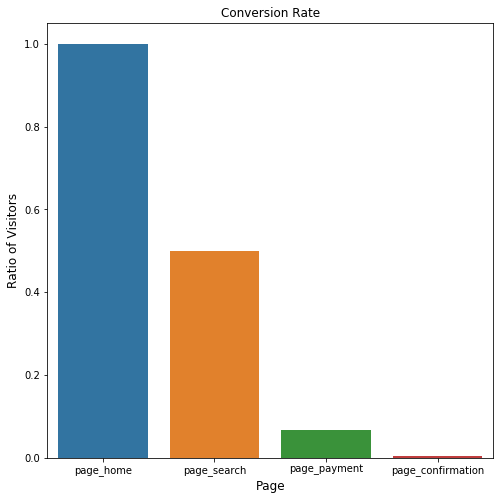

In [161]:
fig,ax = plt.subplots(1,1,figsize=(8, 8))
sns.barplot(x='index',y='conversion',data=probNext)
ax.set_title('Conversion Rate')
ax.set_xlabel('Page', fontsize=12)
ax.set_ylabel('Ratio of Visitors', fontsize=12)
plt.show()

##### EDA

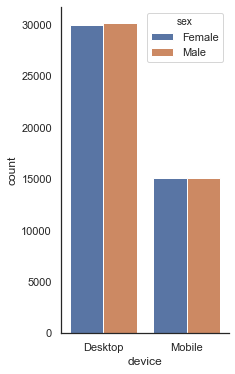

In [162]:
plt.figure(figsize=(3,6))
sns.set(style='white')
ax = sns.countplot(x='device', hue='sex',data=data)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)

##### Desktop Users Time Series Analysis 

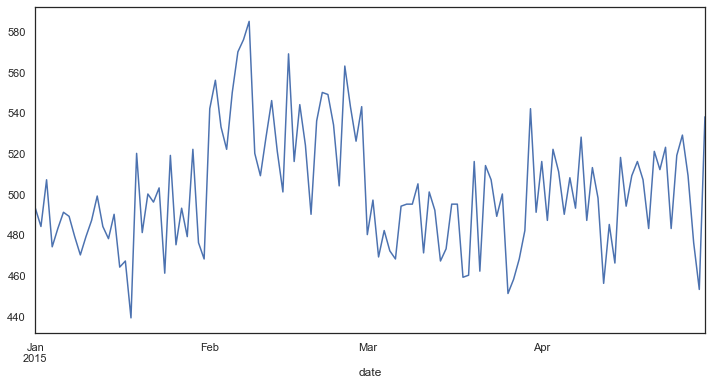

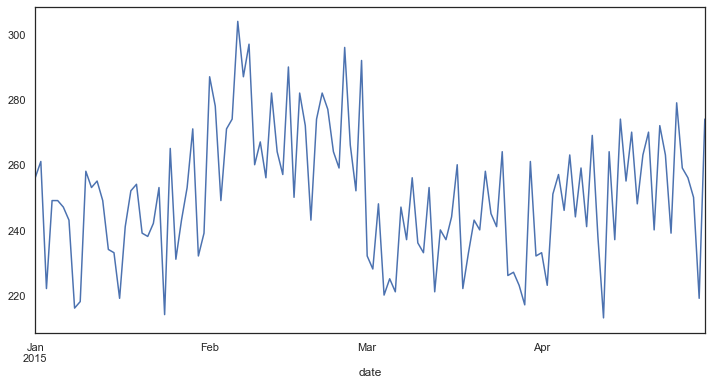

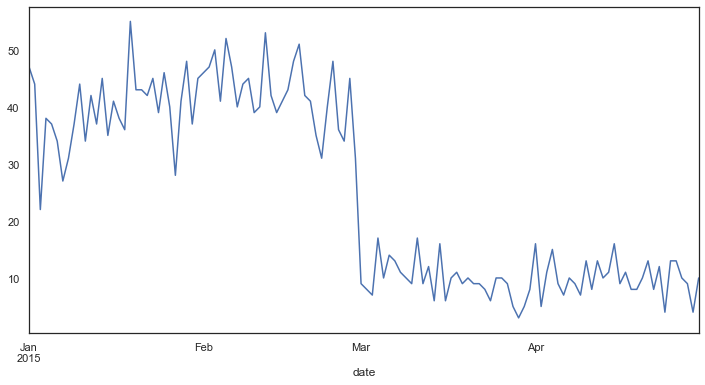

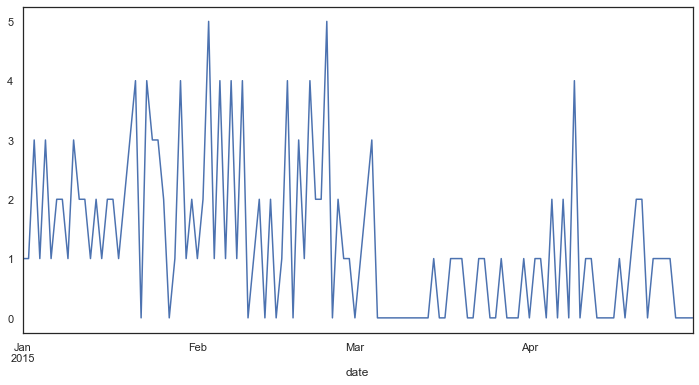

In [165]:
date_groupby = data[(data.device=='Desktop')].groupby('date').count()
plt.figure(figsize=(12,6))
date_groupby['page_home'].plot()
plt.figure(figsize=(12,6))
date_groupby['page_search'].plot()
plt.figure(figsize=(12,6))
date_groupby['page_payment'].plot()
plt.figure(figsize=(12,6))
date_groupby['page_confirmation'].plot()

In [166]:
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN
